## MACHINE LEARNING ASSIGNMENT 1
```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini

Student: Turgunboev Dadakhon
Email: D.TURGUNBOEV@INNOPOLIS.UNIVERSITY
```


## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import seaborn as sns

## Read Data

In [5]:
session_engine = create_engine('sqlite:///F24.ML.Assignment.One.data.db')

query = text('''
SELECT
    oh.*,
    MAX(CASE WHEN op.NAME = 'region_id' THEN opv.VALUE END) AS region_id,
    MAX(CASE WHEN op.NAME = 'order_ready' THEN opv.VALUE END) AS order_ready_date,
    MAX(CASE WHEN op.NAME = 'order_start_prepare' THEN opv.VALUE END) AS order_start_prepare,
    MAX(CASE WHEN op.NAME = 'delivery_distance' THEN opv.VALUE END) AS delivery_distance,
    MAX(CASE WHEN op.NAME = 'profit' THEN opv.VALUE END) AS profit,
    MAX(CASE WHEN op.NAME = 'order_pickup' THEN opv.VALUE END) AS order_pickup_date,
    COUNT(DISTINCT ob.product_id) AS product_count,
    SUM(ob.price) AS total_price
FROM
    order_history oh
LEFT JOIN order_props_value opv ON oh.order_id = opv.order_id
LEFT JOIN order_props op ON opv.ORDER_PROPS_ID = op.ID
LEFT JOIN order_busket ob ON oh.order_id = ob.order_id
LEFT JOIN products p ON ob.product_id = p.product_id AND oh.store_id = p.store_id
GROUP BY
    oh.order_id
            ''')

with session_engine.connect() as conn:
    order_df = pd.read_sql_query(query, conn)

## Data exploration

In [7]:
order_df.head(3)

,order_id,STATUS_ID,store_id,planned_prep_time,DATE_CREATE,region_id,order_ready_date,order_start_prepare,delivery_distance,profit,order_pickup_date,product_count,total_price
0,18671223,F,3750,35.0,2024-05-08 00:01:12,683,2024-05-08 00:25:12,2024-05-08 00:01:21,3934,20.145,08-05-2024 00:53:12,3,241.74
1,18671225,F,5863,15.0,2024-05-08 00:01:46,703,2024-05-08 00:10:29,2024-05-08 00:02:01,560,15.8,08-05-2024 00:38:29,1,189.60
2,18671227,F,8721,20.0,2024-05-08 00:01:38,691,2024-05-08 00:49:19,2024-05-08 00:01:50,4396,6.0040000000000004,08-05-2024 01:17:19,1,180.12


In [8]:
order_df.isnull().sum()

order_id                   0
STATUS_ID                  0
store_id                   0
planned_prep_time          1
DATE_CREATE              273
region_id                  0
order_ready_date       51366
order_start_prepare    51796
delivery_distance          0
profit                 51385
order_pickup_date          0
product_count              0
total_price            14984
dtype: int64

### Missing Values

In [10]:
# Converts specified columns in a DataFrame to numeric and datetime types
cols_to_convert = ['region_id', 'delivery_distance', 'profit']
for col in cols_to_convert:
    order_df[col] = pd.to_numeric(order_df[col],errors='coerce')
    
parse_dates=['DATE_CREATE','order_ready_date','order_start_prepare','order_pickup_date']
for col in parse_dates:
    order_df[col] = pd.to_datetime(order_df[col],format='mixed',errors='coerce')

print(order_df.dtypes)

order_id                        int64
STATUS_ID                      object
store_id                        int64
planned_prep_time             float64
DATE_CREATE            datetime64[ns]
region_id                       int64
order_ready_date       datetime64[ns]
order_start_prepare    datetime64[ns]
delivery_distance               int64
profit                        float64
order_pickup_date      datetime64[ns]
product_count                   int64
total_price                   float64
dtype: object


In [11]:
order_df.isna().sum()

order_id                   0
STATUS_ID                  0
store_id                   0
planned_prep_time          1
DATE_CREATE              273
region_id                  0
order_ready_date       51366
order_start_prepare    51796
delivery_distance          0
profit                 51385
order_pickup_date          0
product_count              0
total_price            14984
dtype: int64

In [12]:
order_df.dropna(subset='DATE_CREATE',inplace=True)

In [13]:
order_df['planned_prep_time'] = order_df.planned_prep_time.fillna(order_df.planned_prep_time.mean())

In [14]:
print(order_df.isnull().sum())

order_id                   0
STATUS_ID                  0
store_id                   0
planned_prep_time          0
DATE_CREATE                0
region_id                  0
order_ready_date       51340
order_start_prepare    51768
delivery_distance          0
profit                 51357
order_pickup_date          0
product_count              0
total_price            14978
dtype: int64


In [15]:
order_df_task_2: pd.DataFrame = order_df

## Split a time series dataset into training and testing sets

In [17]:
# split a time series dataset into training and testing sets without shuffling
from sklearn.model_selection import TimeSeriesSplit, train_test_split #These classes are used for time series cross-validation and splitting data into training and testing sets, respectively.

order_df.sort_values(by='DATE_CREATE',inplace=True)
order_train, order_test = train_test_split(order_df,shuffle=False,test_size=.1)

In [18]:
order_train['time_diff_start']  = order_train['order_start_prepare'] - order_train['DATE_CREATE']
# Find the mean time difference for each store_id
mean_time_train_start = order_train.groupby('store_id')['time_diff_start'].mean()

#Apply calculated mean to order data frame
def fill_order_start_prepare(df:pd.DataFrame):
    # Fill missing values in 'order_start_prepare' using 'DATE_CREATE' + mean time difference for that store
    df['order_start_prepare'] = df.apply(
        lambda row: row['DATE_CREATE'] + mean_time_train_start.get(row['store_id'],pd.Timedelta(0))
                    if pd.isna(row['order_start_prepare']) else row['order_start_prepare'],
        axis=1
    )

In [19]:
order_train['time_diff_ready'] = order_train['order_ready_date'] - order_train['DATE_CREATE']

# 2. Находим среднюю временную разницу для каждого store_id
mean_time_train_ready = order_train.groupby('store_id')['time_diff_ready'].mean()

In [20]:
def fill_order_ready_date(df:pd.DataFrame):
    # Fill missing values in 'order_ready_date' using 'DATE_CREATE' + mean time difference for that store
    df['order_ready_date'] = df.apply(
        lambda row: row['DATE_CREATE'] + mean_time_train_ready.get(row['store_id'], pd.Timedelta(0))
                    if pd.isna(row['order_ready_date']) else row['order_ready_date'],
        axis=1
    )

In [21]:
fill_order_start_prepare(order_train)
fill_order_ready_date(order_train)

fill_order_start_prepare(order_test)
fill_order_ready_date(order_test)

# Drop the time_diff column
order_train.drop(columns=['time_diff_ready', 'time_diff_start'], inplace=True)

In [22]:
# drop data where order_ready_date is before order_start_prepare
def drop_corrupted_data(df:pd.DataFrame):
    corrupted_data = df[df['order_ready_date'] < df['order_start_prepare']]
    df.drop(corrupted_data.index,inplace=True)

drop_corrupted_data(order_train)
drop_corrupted_data(order_test)
order_df[order_df['order_ready_date'] < order_df['order_start_prepare']]

,order_id,STATUS_ID,store_id,planned_prep_time,DATE_CREATE,region_id,order_ready_date,order_start_prepare,delivery_distance,profit,order_pickup_date,product_count,total_price
45,18671395,F,7963,5.0,2024-05-08 00:20:59,683,2024-05-08 00:42:27,2024-05-08 01:35:26,7747,112.4960,2024-08-05 01:10:27,2,843.720
499,18673245,F,11007,10.0,2024-05-08 11:06:53,683,2024-05-08 11:31:31,2024-05-08 11:34:48,1139,52.2980,2024-08-05 11:59:31,4,1260.840
570,18673507,F,9991,11.0,2024-05-08 11:26:44,683,2024-05-08 11:46:47,2024-05-08 12:37:49,2606,8.3582,2024-08-05 12:14:47,1,250.746
575,18673521,F,3527,25.0,2024-05-08 11:37:48,691,2024-05-08 11:46:28,2024-05-08 11:46:33,1810,44.2400,2024-08-05 12:14:28,2,331.800
1105,18675435,F,8211,10.0,2024-05-08 12:56:19,693,2024-05-08 13:17:49,2024-05-08 14:16:34,9403,21.0140,2024-08-05 13:45:49,7,630.420
...,...,...,...,...,...,...,...,...,...,...,...,...,...
516122,20557341,F,3376,5.0,2024-09-05 02:17:17,683,2024-09-05 02:47:17,2024-09-05 03:02:52,5410,94.8000,2024-05-09 03:15:17,2,711.000
516129,20557369,F,10887,10.0,2024-09-05 02:19:57,695,2024-09-05 02:18:21,2024-09-05 02:20:03,23,6.3200,2024-05-09 02:46:21,3,189.600
516357,20558381,F,11193,10.0,2024-09-05 10:43:16,693,2024-09-05 11:13:23,2024-09-05 11:31:59,9427,32.8640,2024-05-09 11:41:23,2,246.480
516448,20558733,F,7149,10.0,2024-09-05 11:27:22,693,2024-09-05 11:29:19,2024-09-05 11:54:50,3128,7.5050,2024-05-09 11:57:19,2,90.060


In [23]:
order_train.isna().sum()

order_id                   0
STATUS_ID                  0
store_id                   0
planned_prep_time          0
DATE_CREATE                0
region_id                  0
order_ready_date           3
order_start_prepare        2
delivery_distance          0
profit                 45934
order_pickup_date          0
product_count              0
total_price            13372
dtype: int64

In [24]:
order_test.isna().sum()

order_id                  0
STATUS_ID                 0
store_id                  0
planned_prep_time         0
DATE_CREATE               0
region_id                 0
order_ready_date          0
order_start_prepare       0
delivery_distance         0
profit                 5073
order_pickup_date         0
product_count             0
total_price            1474
dtype: int64

In [25]:
order_train.dropna(subset=['order_ready_date','order_start_prepare'],inplace=True)
order_test.dropna(subset=['order_ready_date','order_start_prepare'],inplace=True)


In [26]:
cols_to_impute = order_train.columns[order_train.isna().any()]
for col in cols_to_impute:
    mean_train = order_train[col].mean()
    order_train[col] = order_train[col].fillna(mean_train)
    order_test[col] = order_test[col].fillna(mean_train)

In [27]:
y_train = (order_train.order_ready_date - order_train.order_start_prepare) / pd.Timedelta(minutes=1)
y_test = (order_test.order_ready_date - order_test.order_start_prepare) / pd.Timedelta(minutes=1)

In [28]:
# extracting date-related features from specified columns in a DataFrame is well-structured
dates_cols_to_extract = ['DATE_CREATE','order_ready_date','order_start_prepare','order_pickup_date']

def extract_date_feats(df:pd.DataFrame):
    for date_cols in dates_cols_to_extract:
        date_series  = pd.to_datetime(df[date_cols],errors='coerce')
        df[f'{date_cols}_dateYear'] = date_series.dt.year
        df[f'{date_cols}_dateMonth'] = date_series.dt.month
        df[f'{date_cols}_dateDay'] = date_series.dt.day
        df[f'{date_cols}_timeHour'] = date_series.dt.hour
        df[f'{date_cols}_timeMin'] = date_series.dt.minute
        df[f'{date_cols}_timeSec'] = date_series.dt.second

    df.drop(columns=dates_cols_to_extract,inplace=True)

    '''Drop columns with const value (Years of 4 columns are const)'''
    cont_cols =  [col for col in df.columns if df[col].nunique() == 1]
    df.drop(columns=cont_cols,inplace=True)

In [29]:
extract_date_feats(order_train)
extract_date_feats(order_test)

In [30]:
# Encoding Status_Id (categorical fetures)
target_encoding = {'F': 0, 'C': 1}
order_test['STATUS_ID'] = order_test.STATUS_ID.apply(lambda x: target_encoding[x])
order_train['STATUS_ID'] = order_train.STATUS_ID.apply(lambda x: target_encoding[x])

<Figure size 1200x800 with 0 Axes>

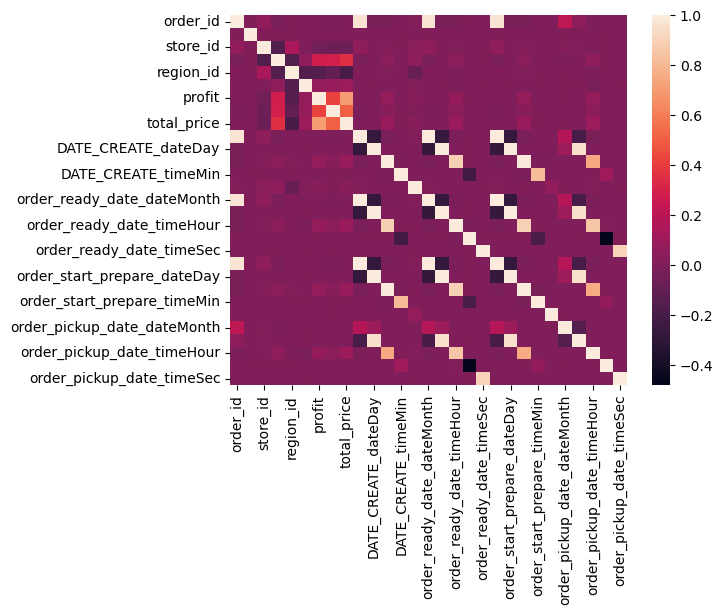

<Figure size 1200x800 with 0 Axes>

In [31]:
# creating a heatmap to visualize the correlation matrix of the order_train DataFrame using Seaborn 
fig = sns.heatmap(order_train.corr())
plt.figure(figsize=(12, 8)) 

In [32]:
y_train.describe()

count    462439.000000
mean         21.389762
std          11.172824
min           0.000000
25%          13.833333
50%          19.814103
75%          27.233333
max         710.796437
dtype: float64

## TASK 1: REGRESSION TASK - PREDICTING PREPARATION TIME

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
    
model = LinearRegression().fit(order_train,y_train)
y_pred_lr = model.predict(order_test)

print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('Mean Squared Error:',mean_squared_error(y_test, y_pred_lr))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_lr))
print('R2:', r2_score(y_test, y_pred_lr))

Root Mean Squared Error: 7.071295526066366
Mean Squared Error: 50.0032204169662
Mean Absolute Error: 4.059824425651443
R2: 0.5714820588006413


In [2]:
# import matplotlib.pyplot as plt

# plt.scatter(y_test, y_pred_lr)
# plt.xlabel("Actual Order Completion Time")
# plt.ylabel("Predicted Order Completion Time")
# plt.title("Actual vs. Predicted Order Completion Time")
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
# plt.show()

In [36]:
# Linear Regression Coefficients
print("----Linear Regression Coefficients----")
print(*[a for a in zip(list(order_train.columns), model.coef_)], sep='\n')

----Linear Regression Coefficients----
('order_id', 1.1291169244740764e-05)
('STATUS_ID', 5.772078352361746)
('store_id', -0.00014833609811833453)
('planned_prep_time', 0.4619044532557759)
('region_id', -0.0002794416533629675)
('delivery_distance', 0.00017583967701396874)
('profit', 0.0013187837639792653)
('product_count', 0.10913077072794494)
('total_price', 0.0007758815453834621)
('DATE_CREATE_dateMonth', 884.7551863811914)
('DATE_CREATE_dateDay', 28.50255431532284)
('DATE_CREATE_timeHour', 1.1970918187696553)
('DATE_CREATE_timeMin', 0.018787675997228574)
('DATE_CREATE_timeSec', -0.009985548358662362)
('order_ready_date_dateMonth', 16766.621815523165)
('order_ready_date_dateDay', 545.8824333239181)
('order_ready_date_timeHour', 22.77222953900371)
('order_ready_date_timeMin', 0.37864491900694197)
('order_ready_date_timeSec', 0.007066661356889785)
('order_start_prepare_dateMonth', -17656.829297060864)
('order_start_prepare_dateDay', -574.5503506135536)
('order_start_prepare_timeHour', 

## Lasso Linear Regression

Aplha: 0.09 losses [88.88560780826745, 78.252119103126, 77.56831088511575, 75.89131260574237, 77.73567407652565]
Average loss for alpha 0.09: 79.66660489575544
Aplha: 0.1 losses [88.7553664675264, 78.25331932702741, 77.56748419821184, 75.8896947964099, 77.73497826572708]
Average loss for alpha 0.1: 79.64016861098052
Aplha: 0.5 losses [88.50170438613314, 78.34962188280416, 77.62738722916771, 75.90842941975643, 77.76653336306603]
Average loss for alpha 0.5: 79.63073525618549
Aplha: 1 losses [88.51245327423935, 78.3851210392199, 77.64071843306544, 75.9382438290803, 77.79573259690326]
Average loss for alpha 1: 79.65445383450165
Aplha: 1.2 losses [88.5179993913025, 78.39755487511385, 77.65087290314479, 75.95091205109169, 77.80739543156605]
Average loss for alpha 1.2: 79.66494693044376


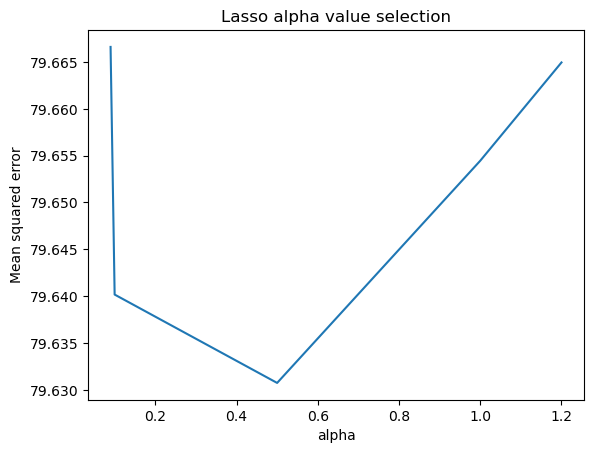

Best value of alpha: 0.5


In [38]:
from sklearn.linear_model import Lasso

alphas = [0.09, 0.1, 0.5, 1, 1.2]
losses = []
tscv = TimeSeriesSplit(n_splits=5)

for alpha in alphas:
    fold_losses = []  # to store loss for each fold
    for train_index, test_index in tscv.split(order_train):
        # Split data into training and validation sets
        X_train, X_val = order_train.iloc[train_index], order_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Initialize Lasso model with the current alpha value
        lasso = Lasso(alpha=alpha)

        # Fit the model on the training set
        lasso.fit(X_train, y_train_fold)

        # Predict on the validation set
        y_pred_val = lasso.predict(X_val)

        # Calculate mean squared error and store it
        mse = mean_squared_error(y_val_fold, y_pred_val)
        fold_losses.append(mse)

    print(f'Aplha: {alpha} losses {fold_losses}')
    avg_loss = np.mean(fold_losses)
    losses.append(avg_loss)

    print(f'Average loss for alpha {alpha}: {avg_loss}')

plt.plot(alphas, losses)
plt.title("Lasso alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha:", best_alpha)

In [39]:
lasso = Lasso(alpha=0.5).fit(order_train, y_train)
y_pred_lasso = lasso.predict(order_test)

print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Mean Squared Error:',mean_squared_error(y_test, y_pred_lasso))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_lasso))
print('R2:', r2_score(y_test, y_pred_lasso))

Root Mean Squared Error: 8.7361035901741
Mean Squared Error: 76.3195059382528
Mean Absolute Error: 6.341528911235648
R2: 0.3459565746906237


In [40]:
# Lasso Regularization Coefficients
print("----Lasso Coefficients----")
print(*[a for a in zip(list(order_train.columns), lasso.coef_)], sep='\n')

----Lasso Coefficients----
('order_id', 1.969271554702515e-08)
('STATUS_ID', 0.0)
('store_id', -0.0002521811409946427)
('planned_prep_time', 0.7384025596943913)
('region_id', 0.0)
('delivery_distance', 0.000282649572901577)
('profit', 0.001913151142361892)
('product_count', 0.0)
('total_price', 0.0016022915271443644)
('DATE_CREATE_dateMonth', 0.0)
('DATE_CREATE_dateDay', -0.0)
('DATE_CREATE_timeHour', -0.0)
('DATE_CREATE_timeMin', -0.0)
('DATE_CREATE_timeSec', -0.014139017421891028)
('order_ready_date_dateMonth', 0.0)
('order_ready_date_dateDay', -0.0)
('order_ready_date_timeHour', -0.0)
('order_ready_date_timeMin', -0.0)
('order_ready_date_timeSec', 0.0)
('order_start_prepare_dateMonth', 0.0)
('order_start_prepare_dateDay', -0.0)
('order_start_prepare_timeHour', -0.005772944947092382)
('order_start_prepare_timeMin', -0.0)
('order_start_prepare_timeSec', -0.00013763289629876868)
('order_pickup_date_dateMonth', -0.0)
('order_pickup_date_dateDay', -0.0)
('order_pickup_date_timeHour', -2.

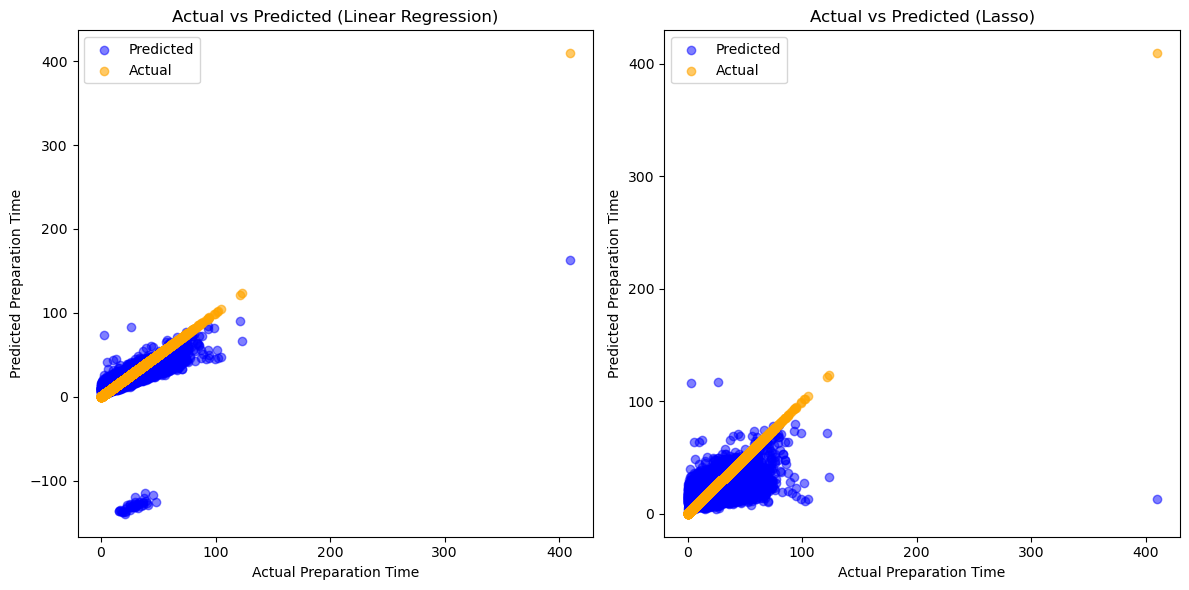

In [41]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))  # Create a figure with a custom size

# First subplot for Model 1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.scatter(y_test, y_pred_lr, color='blue', label='Predicted', alpha=0.5)  # Plot predictions
plt.scatter(y_test, y_test, color='orange', label='Actual', alpha=0.6)    # Plot actual values

# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Prediction')  # Diagonal line
plt.xlabel('Actual Preparation Time')
plt.ylabel('Predicted Preparation Time')
plt.title(f'Actual vs Predicted (Linear Regression)')
plt.legend()

# Second subplot for Model 2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.scatter(y_test, y_pred_lasso, color='blue', label='Predicted', alpha=0.5)  # Plot predictions
plt.scatter(y_test, y_test, color='orange', label='Actual', alpha=0.6)    # Plot actual values
plt.xlabel('Actual Preparation Time')
plt.ylabel('Predicted Preparation Time')
plt.title(f'Actual vs Predicted (Lasso)')
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()


In [42]:
def plot_coeffs(regressor):
    coefficients = regressor.coef_
    features = order_train.columns
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': coefficients
    })

    # Sort the features by the absolute value of the coefficients
    coef_df['abs_coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

    # Plot the coefficients
    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='blue')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Most Significant Features Affecting Preparation Time')
    plt.gca().invert_yaxis()
    plt.show()

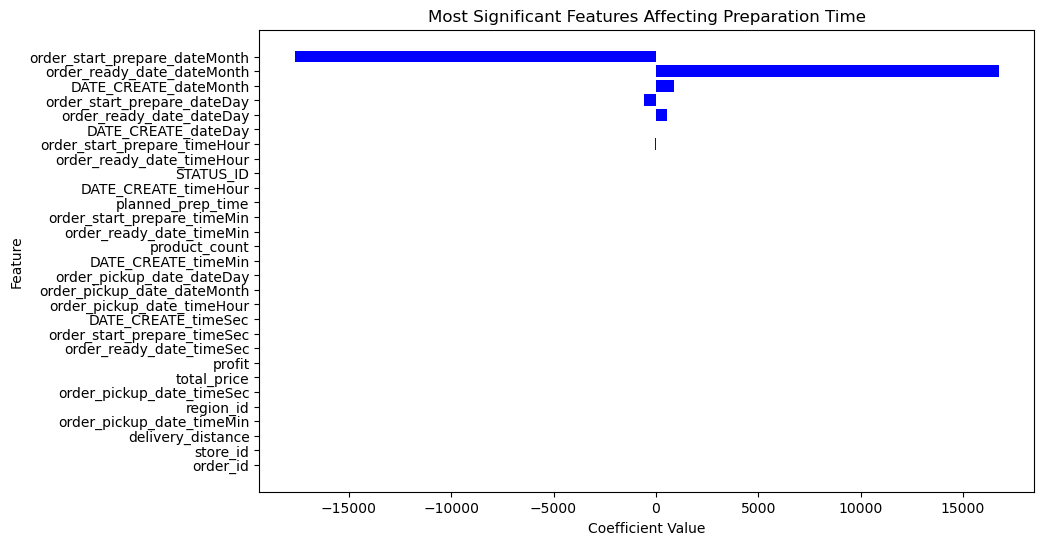

In [43]:
plot_coeffs(regressor=model)

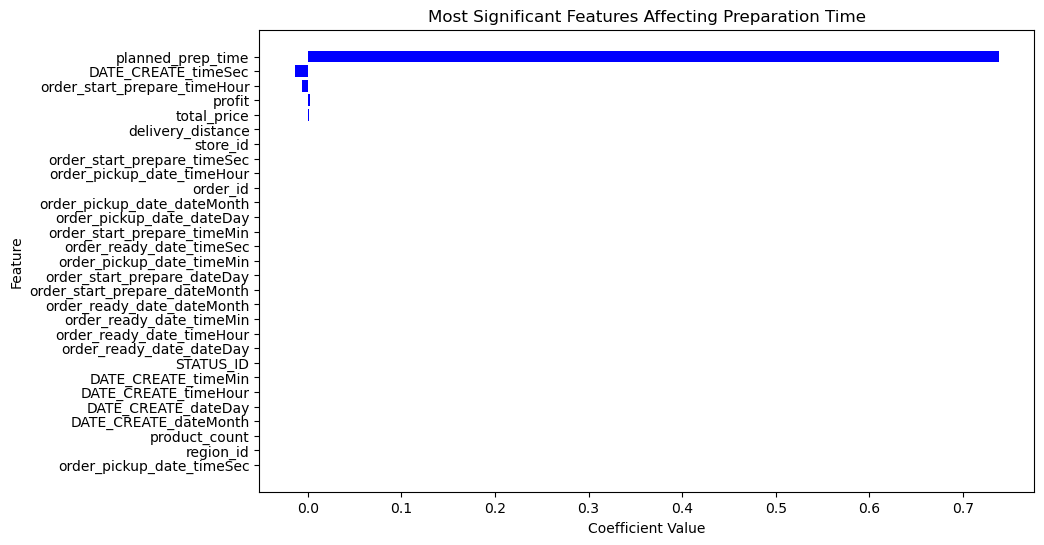

In [44]:
plot_coeffs(regressor=lasso)

## TASK 2: CLASSIFICATION TASK - PREDICTING ON-TIME COMPLETION

<Figure size 1500x500 with 0 Axes>

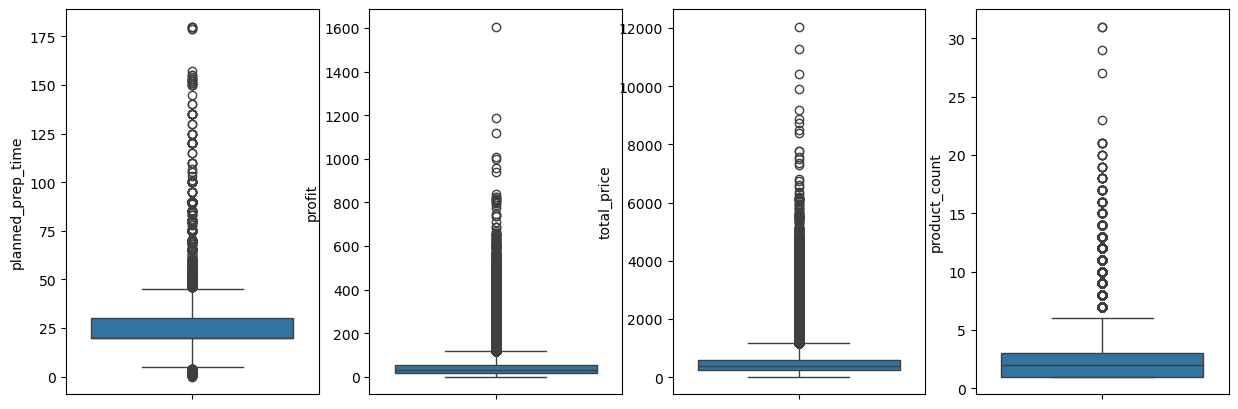

In [46]:
cols_to_remove_outliers = ['planned_prep_time','profit','total_price','product_count']

plt.figure(figsize=(15, 5))
fig,axes = plt.subplots(1, len(cols_to_remove_outliers), figsize=(15,5))
for i,col in enumerate(cols_to_remove_outliers):
    sns.boxplot(y=order_df_task_2[col],ax=axes[i])

In [47]:
for col in ['profit','total_price']:
    Q1 = order_df_task_2[col].quantile(0.25)
    Q3 = order_df_task_2[col].quantile(0.75)
    IQR = Q3 - Q1
    order_df_task_2.query(f'(@Q1 - 1.5 * @IQR) <= {col} <= (@Q3 + 1.5 * @IQR)',inplace=True)

    print("\n\norder_df_task_2 information: \n")

    order_df_task_2.info()



order_df_task_2 information: 

<class 'pandas.core.frame.DataFrame'>
Index: 439660 entries, 0 to 517609
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             439660 non-null  int64         
 1   STATUS_ID            439660 non-null  object        
 2   store_id             439660 non-null  int64         
 3   planned_prep_time    439660 non-null  float64       
 4   DATE_CREATE          439660 non-null  datetime64[ns]
 5   region_id            439660 non-null  int64         
 6   order_ready_date     395865 non-null  datetime64[ns]
 7   order_start_prepare  395618 non-null  datetime64[ns]
 8   delivery_distance    439660 non-null  int64         
 9   profit               439660 non-null  float64       
 10  order_pickup_date    439660 non-null  datetime64[ns]
 11  product_count        439660 non-null  int64         
 12  total_price          426319 non-null  float6

<Figure size 1500x500 with 0 Axes>

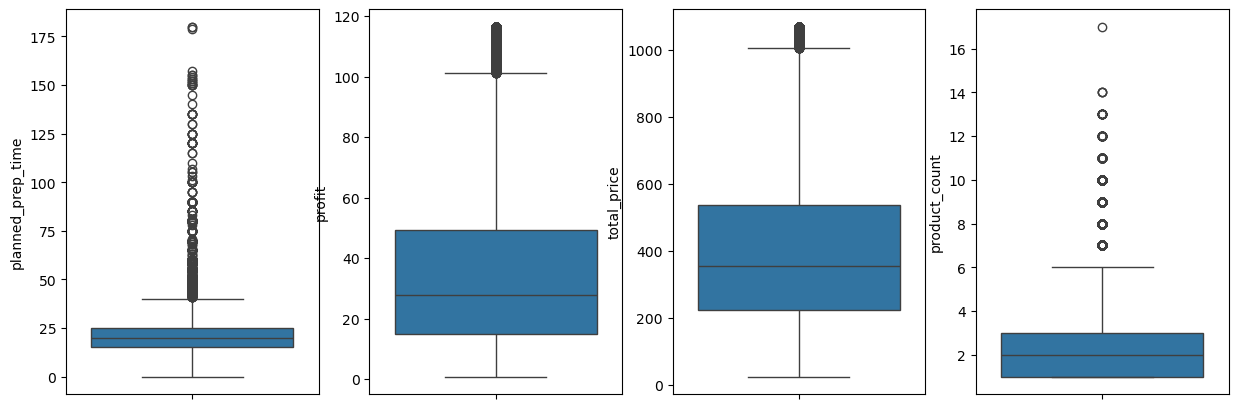

In [48]:
plt.figure(figsize=(15, 5))
fig,axes = plt.subplots(1, len(cols_to_remove_outliers), figsize=(15,5))
for i,col in enumerate(cols_to_remove_outliers):
    sns.boxplot(y=order_df_task_2[col],ax=axes[i])

In [49]:
order_df_task_2.sort_values(by='DATE_CREATE',inplace=True)
order_train, order_test = train_test_split(order_df_task_2,shuffle=False,test_size=.1)

fill_order_start_prepare(order_train)
fill_order_ready_date(order_train)

fill_order_start_prepare(order_test)
fill_order_ready_date(order_test)

# Fill order_start_prepare and order_ready
drop_corrupted_data(order_train)
drop_corrupted_data(order_test)

order_train.dropna(subset=['order_ready_date','order_start_prepare'],inplace=True)
order_test.dropna(subset=['order_ready_date','order_start_prepare'],inplace=True)

order_test.isna().sum()

order_id               0
STATUS_ID              0
store_id               0
planned_prep_time      0
DATE_CREATE            0
region_id              0
order_ready_date       0
order_start_prepare    0
delivery_distance      0
profit                 0
order_pickup_date      0
product_count          0
total_price            0
dtype: int64

In [50]:
real_prep_time_train = (order_train.order_ready_date - order_train.order_start_prepare) / pd.Timedelta(minutes=1)
y_train =  ((order_train.planned_prep_time - real_prep_time_train).abs() <= 5).map(int)
real_prep_time_test = (order_test.order_ready_date - order_test.order_start_prepare) / pd.Timedelta(minutes=1)
y_test = ((order_test.planned_prep_time - real_prep_time_test).abs() <= 5).map(int)

In [51]:
extract_date_feats(order_train)
extract_date_feats(order_test)

In [52]:
target_encoding = {'F': 0, 'C': 1}
order_test['STATUS_ID'] = order_test.STATUS_ID.apply(lambda x: target_encoding[x])
order_train['STATUS_ID'] = order_train.STATUS_ID.apply(lambda x: target_encoding[x])

In [53]:
from sklearn.preprocessing import RobustScaler,StandardScaler

transformer = RobustScaler().fit(order_train)
transformer.transform(order_train)
transformer.transform(order_test)

array([[ 0.97722505,  0.        ,  0.01843499, ...,  0.57142857,
         0.63333333, -0.53333333],
       [ 0.97712028,  0.        , -0.56226711, ...,  0.71428571,
        -0.4       ,  0.76666667],
       [ 0.97723669,  0.        ,  0.74249853, ...,  0.57142857,
         0.56666667,  0.3       ],
       ...,
       [ 1.19249744,  0.        ,  0.90606001, ...,  0.        ,
        -0.76666667,  0.3       ],
       [ 1.19253237,  0.        , -0.46067856, ...,  0.        ,
        -0.86666667,  0.7       ],
       [ 1.19254168,  0.        , -0.23357521, ...,  0.        ,
        -0.96666667, -0.96666667]])

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score

# fit Logistic Regression
clf = LogisticRegression(random_state=0,max_iter=1000).fit(order_train, y_train)
y_test_pred = clf.predict(order_test)

# calculate metrics
print('Testing accuracy = {}'.format(accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(recall_score(y_test, y_test_pred)))

Testing accuracy = 0.5645366474214698
Testing precision = 0.5534035656401944
Testing recall = 0.35720263625902293


In [55]:
# Logistic Regression Coefficients
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(order_train.columns), clf.coef_[0])], sep='\n')

----Logistic Regression Coefficients----
('order_id', -4.239167387267537e-08)
('STATUS_ID', -7.993588407177406e-07)
('store_id', -7.313519059640205e-06)
('planned_prep_time', -0.03956750735342745)
('region_id', 0.0025211841452956064)
('delivery_distance', -1.6157181820521056e-05)
('profit', 0.0007638274011326511)
('product_count', -0.0007065648357298223)
('total_price', 0.0003229221424824026)
('DATE_CREATE_dateMonth', 0.0005936962815978286)
('DATE_CREATE_dateDay', -0.00024287704406142862)
('DATE_CREATE_timeHour', -0.0002656724809650139)
('DATE_CREATE_timeMin', -2.871017854239653e-06)
('DATE_CREATE_timeSec', -0.000748739889804284)
('order_ready_date_dateMonth', 0.0005940809840836486)
('order_ready_date_dateDay', -0.00023356140059666158)
('order_ready_date_timeHour', -0.0006868054294765895)
('order_ready_date_timeMin', -0.001192417081571191)
('order_ready_date_timeSec', -0.0001979711414042233)
('order_start_prepare_dateMonth', 0.0005935615944344175)
('order_start_prepare_dateDay', -0.000

E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


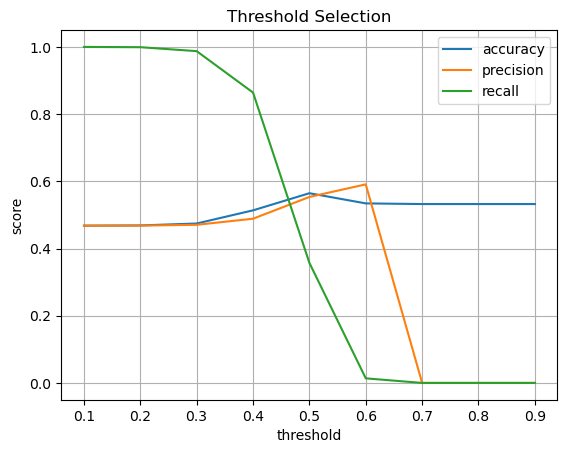

In [56]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pred_proba = clf.predict_proba(order_test)

results = [[], [], []]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(accuracy_score(y_test, y_test_pred_thr))  # accuracy
    results[1].append(precision_score(y_test, y_test_pred_thr))  # precision
    results[2].append(recall_score(y_test, y_test_pred_thr))  # recall

plt.plot(thresholds, results[0], label='accuracy')
plt.plot(thresholds, results[1], label='precision')
plt.plot(thresholds, results[2], label='recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

In [57]:
def calc_confusion_matrix(true_labels, pred_labels):
    num_labels = np.unique(true_labels).size
    cm = np.zeros((num_labels, num_labels), dtype=int)
    for a, p in zip(true_labels, pred_labels):
        cm[a][p] += 1
    return cm

In [58]:
calc_confusion_matrix(y_test,y_test_pred)

array([[16247,  5511],
       [12289,  6829]])

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(order_train, y_train)
y_pred_svc = model.predict(order_test)

# calculate metrics
print('Testing accuracy = {}'.format(accuracy_score(y_test, y_pred_svc)))
print('Testing precision = {}'.format(precision_score(y_test, y_pred_svc)))
print('Testing recall = {}'.format(recall_score(y_test, y_pred_svc)))